In [25]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='ticks')

In [2]:
def read_data(infile, parse_col, date_str):
    """
    Function to read data.

    Parameters
    ----------
    infile : str
        Path to data.
    parse_col : str
        Column name of time variable.
    date_str : str
        String for datetime conversion.

    returns
    -------
    data : pd.DataFrame
    """
    def dateparse(x): return pd.datetime.strptime(x, date_str)
    data = pd.read_csv(infile, parse_dates=[parse_col], date_parser=dateparse)
    data.index = data[parse_col]
    return data.drop(columns=[parse_col], axis=1)

In [3]:
# define base directory
inpath = sys.path[0]
print(os.listdir(inpath))

# read the backscatter and soil moisture data
data = read_data(infile=os.path.join(inpath, 'Asheville-13-S_data.csv'),
                 parse_col='Time', date_str='%Y-%m-%d %H:%M:%S.%f')
print(data.head())

# read ancillary data and store as dict
site_specs_df = pd.read_csv(os.path.join(inpath, 'Asheville-13-S_sitespecifics.csv'),
                        delimiter=':', header=None)
site_specs = {}
for k, v in zip(site_specs_df.loc[:, 0], site_specs_df.loc[:, 1]):
    site_specs[k] = v
print(site_specs)

['Asheville-13-S_sitespecifics.csv', 'Asheville-13-S_data.csv', 'ex2.ipynb', '.ipynb_checkpoints']
                            SSM_IS  SSM_LSM     SIG40     SLOPE     CURVE  \
Time                                                                        
2010-01-18 16:00:37.500004   0.336  0.29664 -8.136676 -0.087746  0.000203   
2010-01-20 02:58:58.124012   0.342  0.27505 -8.136666 -0.087717  0.000218   
2010-01-21 14:58:35.624999   0.350  0.38549 -7.747195 -0.087693  0.000227   
2010-01-22 02:17:33.750000   0.361  0.33030 -8.009717 -0.087689  0.000238   
2010-01-23 01:56:58.124999   0.351  0.31426 -8.311224 -0.087646  0.000247   

                                sigf      sigm      siga       incf  \
Time                                                                  
2010-01-18 16:00:37.500004 -8.175597 -8.153164 -8.081265  59.249040   
2010-01-20 02:58:58.124012 -8.241362 -8.011751 -8.156887  46.319836   
2010-01-21 14:58:35.624999 -7.693698 -7.728050 -7.819838  52.360992   
2010-0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1139c6ba8>,
      dtype=object)

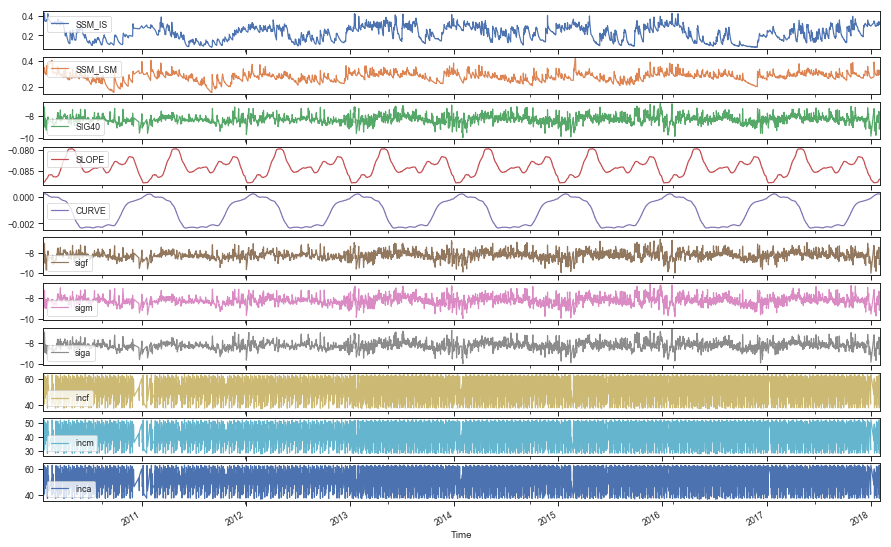

In [4]:
data.plot(subplots=True, figsize=(15,10))

## Experminent 1: directly from sig40 -> sig25

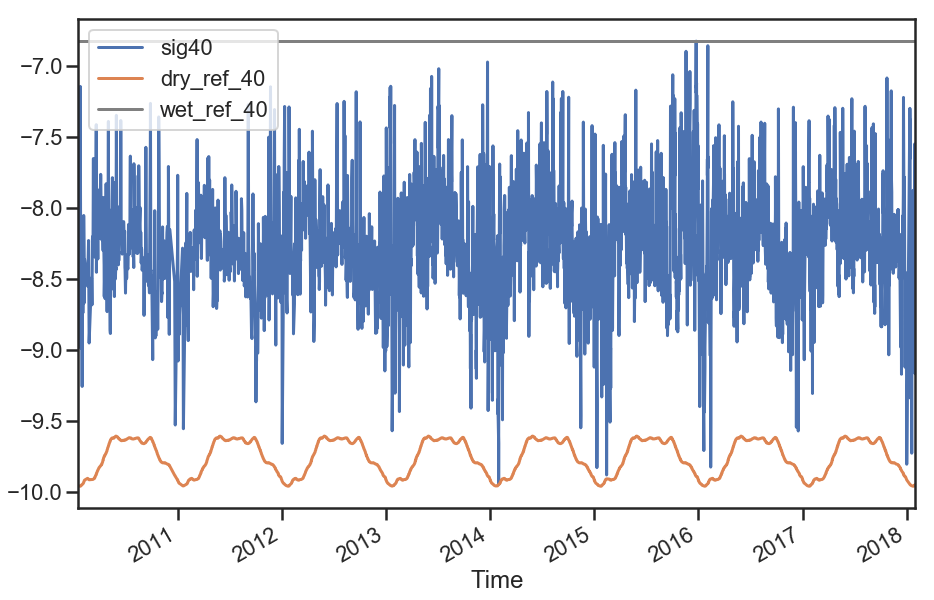

In [97]:
sig40 = data['SIG40']
sig40.name = 'sig40'
slope = data['SLOPE']
curve = data['CURVE']

# sig40 -> sig25
sig25 = sig40 + (slope * (-15)) + (curve * 0.5 * (-15)**2)
sig25.name = 'sig25'

# calculate wet reference (one value) at 40°
wet_ref_40 = sig40.max()

# calculate dry reference (one value) at 25°
dry_ref_25 = sig25.min()

# go back to wet/general reference at 40° to have dry_ref, wet_ref and backscatter at 40° to calculate SM
dry_ref_40 = dry_ref_25 - (slope * (-15)) - (curve * 0.5 * (-15)**2)
dry_ref_40.name = 'dry_ref_40'

# create plot
fig, ax = plt.subplots(figsize=(15,10))
sig40.plot(ax=ax)
dry_ref_40.plot(ax=ax)
ax.axhline(wet_ref_40, linestyle='-', color='grey', label='wet_ref_40')
plt.legend()

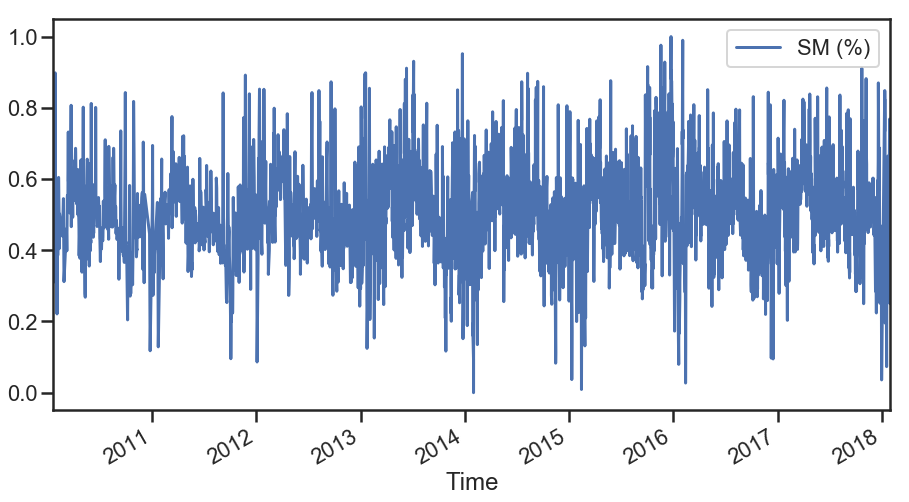

In [103]:
# Soil moisture
ms = (sig40 - dry_ref_40) / (wet_ref_40 - dry_ref_40)
ms.plot(figsize=(15,8), label='SM (%)')
plt.legend()

## Expertiment 2: Scatter plot of backscatter vs. incidence angle

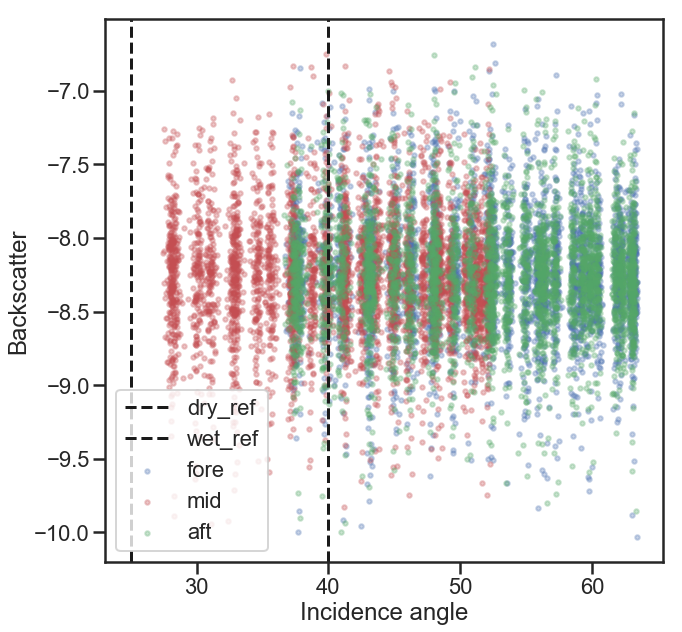

In [45]:
triplets = data[['sigf', 'sigm', 'siga', 'incf', 'incm', 'inca']]


fig, ax = plt.subplots(figsize=(10,10))

for beam, inc, sig, c in zip(['fore', 'mid', 'aft'], ['incf', 'incm', 'inca'], ['sigf', 'sigm', 'siga'], ['b','r','g']):
    triplets.plot.scatter(x=inc, y=sig, c=c, ax=ax, label=beam, alpha=0.3)
    
ax.axvline(25, label='dry_ref', linestyle='--', color='k')
ax.axvline(40, label='wet_ref', linestyle='--', color='k')

ax.set_xlabel('Incidence angle')
ax.set_ylabel('Backscatter')

plt.legend()


## Estimate slope and curvature at reference angles from measurement triplets

,inc_mid_fore,slope_mid_fore,inc_mid_aft,slope_mid_aft
Time,,,,
2010-01-18 16:00:37.500004,-5.561997,-0.002017,-5.626454,0.006389
2010-01-20 02:58:58.124012,-5.331018,-0.021535,-5.288425,-0.013722
2010-01-21 14:58:35.624999,-5.562361,0.003088,-5.572361,-0.008236
2010-01-22 02:17:33.750000,-4.895841,-0.007236,-4.886983,-0.006849
2010-01-23 01:56:58.124999,-5.576511,-0.017608,-5.535729,-0.016721


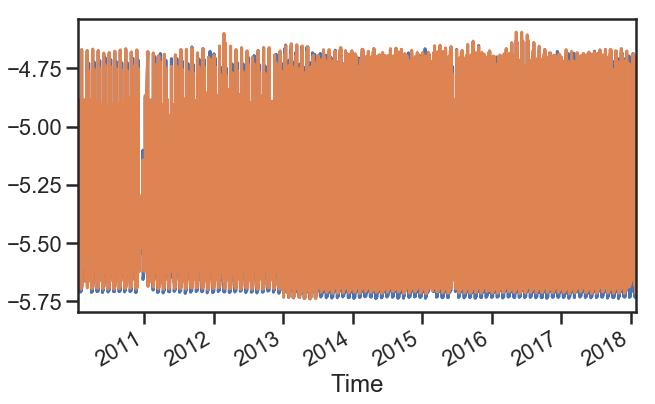

In [59]:
def slope_estimate(slope1, slope2, inc1, inc2):
    """Estimate one slope from two of the three triplets."""
    idx = slope1.index
    inc_angle = (inc1 - inc2) / 2
    slope = (slope1 - slope2) / (inc1 - inc2)
    return inc_angle, slope

# mid and fore beam slope
inc_angle_mid_fore, slope_mid_fore = slope_estimate(data['sigm'], data['sigf'], data['incm'], data['incf'])

inc_angle_mid_fore.name = 'inc_mid_fore'
slope_mid_fore.name = 'slope_mid_fore'
# mid and aft beam slope
inc_angle_mid_aft, slope_mid_aft = slope_estimate(data['sigm'], data['siga'], data['incm'], data['inca'])

inc_angle_mid_aft.name = 'inc_mid_aft'
slope_mid_aft.name = 'slope_mid_aft'

ax = inc_angle_mid_fore.plot(figsize=(10,6))
inc_angle_mid_aft.plot(ax=ax)

test = pd.concat([inc_angle_mid_fore, slope_mid_fore, inc_angle_mid_aft, slope_mid_aft], axis=1)
test.head()